<a href="https://colab.research.google.com/github/sergiosgd01/03MIAR---Algoritmos-de-Optimizacion/blob/main/TRABAJO_PRACTICO/TrabajoPractico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos de optimización - Trabajo Práctico
**Nombre y Apellidos:** Sergio Guijarro Domínguez  
**Github:** https://github.com/sergiosgd01/03MIAR---Algoritmos-de-Optimizacion/blob/main/TRABAJO_PRACTICO/TrabajoPractico.ipynb  
**Google Colab:** https://colab.research.google.com/drive/1jK6YJKUd-LuKbkLbhhxEoWV4ufi3kwtM?usp=drive_link

**Problema seleccionado:**
> 1. Sesiones de doblaje

## Descripción del problema

Se precisa coordinar el doblaje de una película. Los actores del doblaje deben coincidir en las tomas en las que sus personajes aparecen juntos. Los actores cobran todos la misma cantidad por cada **día** que se desplazan al estudio, independientemente del número de tomas grabadas ese día.

**No es posible grabar más de 6 tomas por día.**

El objetivo es planificar las sesiones por día de manera que el **gasto por los servicios de los actores sea el menor posible**.

- Número de actores: 10  
- Número de tomas: 30  
- Máximo tomas/día: 6  
- Días mínimos necesarios: 5                                    

## Modelo

### ¿Cómo represento el espacio de soluciones?

Una solución es una lista de 30 elementos donde `solucion[i]` indica el día asignado a la toma `i` (índice 0-4 para los 5 días)
```
solucion = [dia_toma_0, dia_toma_1, ..., dia_toma_29]
```

### ¿Cuál es la función objetivo?

El objetivo es minimizar la suma de actores distintos que acuden al estudio cada día

$$\text{coste} = \sum_{d=1}^{D} |\{\text{actores que participan en alguna toma del día } d\}|$$

Para cada día se calcula la unión de actores de todas sus tomas asignadas.

### ¿Cómo implemento las restricciones?

La única restricción es que no puede haber más de 6 tomas por día.

En la generación aleatoria se construye la solución distribuyendo exactamente 6 tomas por día. En la búsqueda local los movimientos consisten en intercambiar tomas entre días (swap), lo que hace que la restricción se mantenga sola.

## Análisis

### ¿Qué complejidad tiene el problema?

El problema es NP-hard, es una variante del bin-packing y no se puede resolver de forma óptima en tiempo polinomial.

### Contabilización del espacio de soluciones

Con 30 tomas repartidas en 5 días de exactamente 6 tomas cada uno, el número de formas distintas de asignarlas es:

$$\frac{30!}{(6!)^5 \times 5!} \approx 4.26 \times 10^{16}$$

Si consideramos asignaciones sin restricción de balance (cada toma puede ir a cualquiera de los 5 días):

$$5^{30} \approx 9.31 \times 10^{20}$$

Esto hace **completamente inviable la búsqueda exhaustiva** y justifica el uso de técnicas heurísticas.

## Diseño

### ¿Qué técnica utilizo? ¿Por qué?

Se implementan **dos técnicas** para comparar resultados:

1. **Búsqueda Aleatoria (Random Search):** Se generan miles de soluciones aleatorias válidas y se conserva la mejor. Sirve como baseline de referencia.

2. **Búsqueda Local con Multi-Reinicio (Hill Climbing):** Partiendo de una solución inicial aleatoria, se exploran vecinos (intercambiando tomas entre días). Se acepta el movimiento si mejora el coste. Se repite desde múltiples puntos de inicio para evitar quedar atrapados en óptimos locales.

**¿Por qué estas técnicas?**
- El espacio de búsqueda (~10²⁰) hace inviable la exploración exhaustiva.
- El operador de swap preserva la validez de la solución de forma natural (no rompe la restricción de 6 tomas/día).
- La función objetivo es rápida de evaluar, lo que permite explorar muchos vecinos en poco tiempo.
- Los múltiples reinicios compensan el problema de los óptimos locales del hill climbing puro.

In [20]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Datos del problema: filas = tomas, columnas = actores
# 1 si el actor sale en esa toma, 0 si no

datos = [
    [1,1,1,1,1,0,0,0,0,0],
    [0,0,1,1,1,0,0,0,0,0],
    [0,1,0,0,1,0,1,0,0,0],
    [1,1,0,0,0,0,1,1,0,0],
    [0,1,0,1,0,0,0,1,0,0],
    [1,1,0,1,1,0,0,0,0,0],
    [1,1,0,1,1,0,0,0,0,0],
    [1,1,0,0,0,1,0,0,0,0],
    [1,1,0,1,0,0,0,0,0,0],
    [1,1,0,0,0,1,0,0,1,0],
    [1,1,1,0,1,0,0,1,0,0],
    [1,1,1,1,0,1,0,0,0,0],
    [1,0,0,1,1,0,0,0,0,0],
    [1,0,1,0,0,1,0,0,0,0],
    [1,1,0,0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0,0,0,1],
    [1,0,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0],
    [1,0,1,0,0,0,0,0,0,0],
    [1,0,1,1,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,1,0,0],
    [1,1,1,1,0,0,0,0,0,0],
    [1,0,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0],
    [1,1,0,1,0,0,0,0,0,1],
    [1,0,1,0,1,0,0,0,1,0],
    [0,0,0,1,1,0,0,0,0,0],
    [1,0,0,1,0,0,0,0,0,0],
    [1,0,0,0,1,1,0,0,0,0],
    [1,0,0,1,0,0,0,0,0,0],
]

datos = np.array(datos)

NUM_TOMAS = 30
NUM_ACTORES = 10
MAX_TOMAS_DIA = 6
NUM_DIAS = NUM_TOMAS // MAX_TOMAS_DIA  # sale 5 dias

print(f"Matriz de datos: {datos.shape}")
print(f"Número de tomas: {NUM_TOMAS}")
print(f"Número de actores: {NUM_ACTORES}")
print(f"Máximo tomas por día: {MAX_TOMAS_DIA}")
print(f"Días mínimos necesarios: {NUM_DIAS}")

Matriz de datos: (30, 10)
Número de tomas: 30
Número de actores: 10
Máximo tomas por día: 6
Días mínimos necesarios: 5


In [21]:
# calcula el coste total, actores distintos que van al estudio cada dia
def calcular_coste(solucion, datos, num_dias):
    coste = 0
    for dia in range(num_dias):
        tomas_idx = [i for i, d in enumerate(solucion) if d == dia]
        if tomas_idx:
            actores_dia = np.any(datos[tomas_idx], axis=0)
            coste += int(np.sum(actores_dia))
    return coste


# comprueba que ningún día tenga más tomas de las permitidas
def es_valida(solucion, num_dias, max_tomas_dia):
    for dia in range(num_dias):
        if sum(1 for d in solucion if d == dia) > max_tomas_dia:
            return False
    return True


# reparte las tomas aleatoriamente entre los días, 6 por día
def generar_solucion_aleatoria(num_tomas, num_dias, max_tomas_dia):
    tomas = list(range(num_tomas))
    random.shuffle(tomas)
    solucion = [0] * num_tomas
    for dia in range(num_dias):
        inicio = dia * max_tomas_dia
        fin = inicio + max_tomas_dia
        for toma in tomas[inicio:fin]:
            solucion[toma] = dia
    return solucion


# prueba rápida para ver que funciona
sol_test = generar_solucion_aleatoria(NUM_TOMAS, NUM_DIAS, MAX_TOMAS_DIA)
print(f"Solución de prueba: {sol_test}")
print(f"Coste: {calcular_coste(sol_test, datos, NUM_DIAS)}")
print(f"¿Es válida?: {es_valida(sol_test, NUM_DIAS, MAX_TOMAS_DIA)}")

Solución de prueba: [3, 3, 2, 0, 1, 0, 4, 0, 4, 1, 0, 2, 3, 2, 1, 4, 2, 3, 0, 1, 1, 2, 1, 0, 4, 2, 4, 4, 3, 3]
Coste: 36
¿Es válida?: True


In [22]:
# tecnica 1 - busqueda aleatoria
# generamos 10000 soluciones random y nos quedamos con la que tenga menor coste

def busqueda_aleatoria(num_iteraciones, datos, num_tomas, num_dias, max_tomas_dia):
    mejor_solucion = None
    mejor_coste = 999999
    historico = []

    for _ in range(num_iteraciones):
        sol = generar_solucion_aleatoria(num_tomas, num_dias, max_tomas_dia)
        coste = calcular_coste(sol, datos, num_dias)
        historico.append(coste)
        if coste < mejor_coste:
            mejor_coste = coste
            mejor_solucion = sol.copy()

    return mejor_solucion, mejor_coste, historico


t0 = time.time()
sol_aleatoria, coste_aleatorio, hist_aleatorio = busqueda_aleatoria(
    10000, datos, NUM_TOMAS, NUM_DIAS, MAX_TOMAS_DIA
)
t1 = time.time()

print(f"Mejor coste: {coste_aleatorio} actores-dia")
print(f"Tiempo: {t1-t0:.2f} segundos")

for dia in range(NUM_DIAS):
    tomas_idx = [i for i, d in enumerate(sol_aleatoria) if d == dia]
    tomas_dia = [i+1 for i in tomas_idx]
    actores = np.any(datos[tomas_idx], axis=0)
    actores_lista = [i+1 for i, a in enumerate(actores) if a]
    print(f"Dia {dia+1}: tomas {tomas_dia} -> {len(actores_lista)} actores {actores_lista}")

Mejor coste: 33 actores-dia
Tiempo: 1.67 segundos
Dia 1: tomas [16, 17, 19, 22, 23, 25] -> 5 actores [1, 2, 3, 4, 10]
Dia 2: tomas [4, 8, 14, 18, 24, 29] -> 7 actores [1, 2, 3, 5, 6, 7, 8]
Dia 3: tomas [3, 5, 6, 9, 15, 20] -> 7 actores [1, 2, 3, 4, 5, 7, 8]
Dia 4: tomas [2, 11, 13, 21, 27, 30] -> 7 actores [1, 2, 3, 4, 5, 6, 8]
Dia 5: tomas [1, 7, 10, 12, 26, 28] -> 7 actores [1, 2, 3, 4, 5, 6, 9]


In [23]:
# tecnica 2 - busqueda local con multirestart (hill climbing)
# el vecino se genera intercambiando dos tomas de dias distintos (swap)
# al hacer swap la restriccion de 6 tomas/dia se mantiene sola
# repetimos desde varios puntos de inicio para no quedarnos en un optimo local

def generar_vecino(solucion):
    vecino = solucion[:]
    toma1 = random.randint(0, len(solucion) - 1)
    toma2 = random.randint(0, len(solucion) - 1)
    while vecino[toma1] == vecino[toma2]:
        toma2 = random.randint(0, len(solucion) - 1)
    vecino[toma1], vecino[toma2] = vecino[toma2], vecino[toma1]
    return vecino


def busqueda_local(solucion_inicial, datos, num_dias, max_iter=20000, max_sin_mejora=3000):
    solucion = solucion_inicial[:]
    coste = calcular_coste(solucion, datos, num_dias)
    mejor_sol = solucion[:]
    mejor_coste = coste
    sin_mejora = 0
    historico = [coste]

    for _ in range(max_iter):
        vecino = generar_vecino(solucion)
        coste_vecino = calcular_coste(vecino, datos, num_dias)

        if coste_vecino < coste:
            solucion = vecino
            coste = coste_vecino
            sin_mejora = 0
            if coste < mejor_coste:
                mejor_coste = coste
                mejor_sol = solucion[:]
        else:
            sin_mejora += 1

        historico.append(coste)
        if sin_mejora >= max_sin_mejora:
            break

    return mejor_sol, mejor_coste, historico


def busqueda_local_multirestart(n_reinicios, datos, num_tomas, num_dias, max_tomas_dia):
    mejor_sol_global = None
    mejor_coste_global = 999999
    costes_por_reinicio = []

    for r in range(n_reinicios):
        sol_ini = generar_solucion_aleatoria(num_tomas, num_dias, max_tomas_dia)
        sol, coste, _ = busqueda_local(sol_ini, datos, num_dias)
        costes_por_reinicio.append(coste)
        if coste < mejor_coste_global:
            mejor_coste_global = coste
            mejor_sol_global = sol.copy()
        if (r+1) % 10 == 0:
            print(f"reinicio {r+1}/{n_reinicios}, mejor hasta ahora: {mejor_coste_global}")

    return mejor_sol_global, mejor_coste_global, costes_por_reinicio


t0 = time.time()
sol_mr, coste_mr, costes_mr = busqueda_local_multirestart(
    50, datos, NUM_TOMAS, NUM_DIAS, MAX_TOMAS_DIA
)
t1 = time.time()

print(f"mejor coste: {coste_mr} actores-dia")
print(f"tiempo: {t1-t0:.2f} segundos")
print(f"coste medio por reinicio: {np.mean(costes_mr):.2f}")

for dia in range(NUM_DIAS):
    tomas_dia = [i+1 for i, d in enumerate(sol_mr) if d == dia]
    tomas_idx = [i for i, d in enumerate(sol_mr) if d == dia]
    actores = np.any(datos[tomas_idx], axis=0)
    actores_lista = [i+1 for i, a in enumerate(actores) if a]
    print(f"dia {dia+1}: tomas {tomas_dia}, actores ({len(actores_lista)}): {actores_lista}")

reinicio 10/50, mejor hasta ahora: 29
reinicio 20/50, mejor hasta ahora: 29
reinicio 30/50, mejor hasta ahora: 29
reinicio 40/50, mejor hasta ahora: 28
reinicio 50/50, mejor hasta ahora: 28
mejor coste: 28 actores-dia
tiempo: 16.53 segundos
coste medio por reinicio: 30.72
dia 1: tomas [14, 17, 18, 19, 23, 24], actores (3): [1, 3, 6]
dia 2: tomas [7, 10, 11, 21, 26, 27], actores (8): [1, 2, 3, 4, 5, 6, 8, 9]
dia 3: tomas [8, 9, 16, 25, 28, 30], actores (5): [1, 2, 4, 6, 10]
dia 4: tomas [3, 4, 5, 6, 13, 15], actores (6): [1, 2, 4, 5, 7, 8]
dia 5: tomas [1, 2, 12, 20, 22, 29], actores (6): [1, 2, 3, 4, 5, 6]


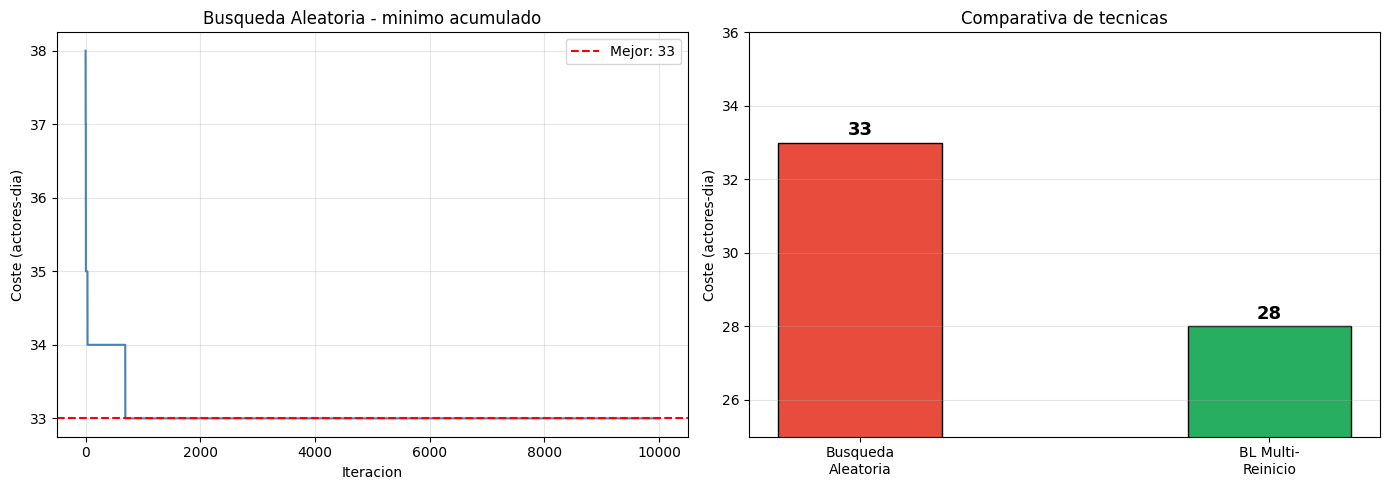

busqueda aleatoria: 33 actores-dia
busqueda local multirestart: 28 actores-dia
mejora: 5 actores-dia


In [24]:
# graficas para comparar los resultados de las dos tecnicas

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# evolucion del minimo en la busqueda aleatoria
minimos = [min(hist_aleatorio[:i+1]) for i in range(len(hist_aleatorio))]
axes[0].plot(minimos, color='steelblue', linewidth=1.5)
axes[0].set_title('Busqueda Aleatoria - minimo acumulado')
axes[0].set_xlabel('Iteracion')
axes[0].set_ylabel('Coste (actores-dia)')
axes[0].axhline(y=coste_aleatorio, color='red', linestyle='--', label=f'Mejor: {coste_aleatorio}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# comparativa entre las dos tecnicas
tecnicas = ['Busqueda\nAleatoria', 'BL Multi-\nReinicio']
costes = [coste_aleatorio, coste_mr]
colores = ['#e74c3c', '#27ae60']
bars = axes[1].bar(tecnicas, costes, color=colores, width=0.4, edgecolor='black')
axes[1].set_title('Comparativa de tecnicas')
axes[1].set_ylabel('Coste (actores-dia)')
axes[1].set_ylim(min(costes) - 3, max(costes) + 3)
for bar, coste in zip(bars, costes):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 str(coste), ha='center', va='bottom', fontweight='bold', fontsize=13)
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"busqueda aleatoria: {coste_aleatorio} actores-dia")
print(f"busqueda local multirestart: {coste_mr} actores-dia")
print(f"mejora: {coste_aleatorio - coste_mr} actores-dia")